# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 363 kB/s 
     |████████████████████████████████| 6.3 MB 24.8 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 2.1 MB 5.0 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase2_all_20220130.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
HFA_poly3 = Polygon([(14.8, 6.3), (14.8, 1.6), (19.6, 1.6), (19.6, 6.3)])

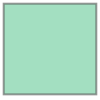

In [ ]:
HFA_poly3

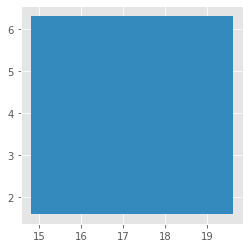

In [ ]:
 p = gpd.GeoSeries(HFA_poly3)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
HFA_poly3_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(HFA_poly3))

In [ ]:
HFA_poly3_gdf

,geometry
0,"POLYGON ((14.80000 6.30000, 14.80000 1.60000, ..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
HFA_join = gpd.sjoin(gdf, HFA_poly3_gdf, how = 'inner')
HFA_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
22,G1221,"19.51,5.567",30/11/2021 10:21,30/11/2021 10:22,19.51,5.567,POINT (19.51000 5.56700),0
24,G1221,"19.11,5.567",30/11/2021 10:22,30/11/2021 10:22,19.11,5.567,POINT (19.11000 5.56700),0
26,G1221,"19.51,5.567",30/11/2021 10:22,30/11/2021 10:22,19.51,5.567,POINT (19.51000 5.56700),0
28,G1221,"19.51,5.567",30/11/2021 10:23,30/11/2021 10:23,19.51,5.567,POINT (19.51000 5.56700),0
30,G1221,"19.11,5.567",30/11/2021 10:23,30/11/2021 10:23,19.11,5.567,POINT (19.11000 5.56700),0
...,...,...,...,...,...,...,...,...
105390,R1306,"16.594,4.286",28/01/2022 13:49,28/01/2022 13:52,16.594,4.286,POINT (16.59400 4.28600),0
105391,R1306,"15.369,4.029",28/01/2022 13:52,28/01/2022 13:55,15.369,4.029,POINT (15.36900 4.02900),0
105471,R1306,"18.077,4.947",28/01/2022 15:54,28/01/2022 15:55,18.077,4.947,POINT (18.07700 4.94700),0
105472,R1306,"18.509,6.151",28/01/2022 15:55,28/01/2022 15:56,18.509,6.151,POINT (18.50900 6.15100),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
HFA_join['newfrom'] = lookup(HFA_join['from'], format='%d/%m/%Y %H:%M')
HFA_join['newto'] = lookup(HFA_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = HFA_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00
...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:26:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal
...,...,...,...,...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 05:26:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          791
mean     0 days 00:20:20.404551201
std      0 days 00:28:32.407392134
min              -1 days +22:12:00
25%                0 days 00:11:30
50%                0 days 00:18:00
75%                0 days 00:24:00
max                0 days 05:26:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal,Friday
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal,Friday
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:16:27.230769230
morning     0 days 00:22:14.576271186
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:20:00
Tuesday,0 days 00:18:29.693877551
Wednesday,0 days 00:17:17.569060773
Thursday,0 days 00:20:58.159509202
Friday,0 days 00:26:00.805369127
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
102
Tuesday
196
Wednesday
181
Thursday
163
Friday
149
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday,morning,10
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday,morning,10
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday,morning,11
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday,morning,10
...,...,...,...,...,...,...,...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday,morning,10
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal,Friday,morning,10
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:30:16.395348837
11   0 days 00:18:05.643564356
12   0 days 00:18:55.428571428
13             0 days 00:18:30
14   0 days 00:18:28.627450980
15   0 days 00:13:39.207920792
16             0 days 00:12:00
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
172
Eleven
202
Twelve
105
One
52
Two
153
Three
101
Four
6


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:22:03.269230769
R   0 days 00:13:56.047904191
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
624
Medical Retinal
167


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday,morning,10,G,73.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday,morning,10,G,62.0000
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday,morning,11,G,42.0000
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday,morning,10,G,41.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday,morning,10,R,256.0000
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10,R,326.0000
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal,Friday,morning,10,R,325.0000
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10,R,326.0000


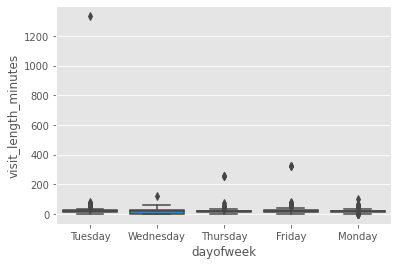

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

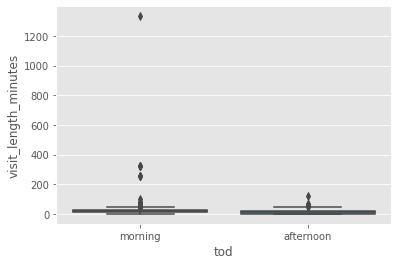

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

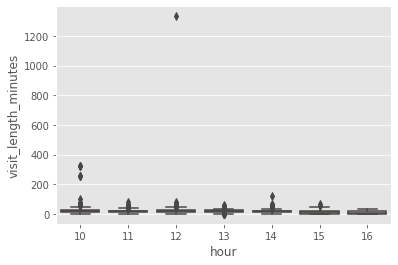

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

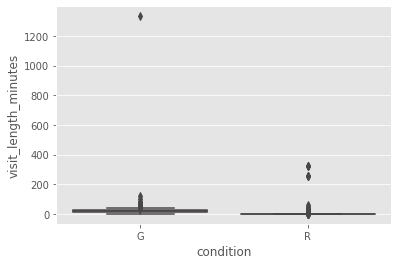

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 188
newfrom                 188
newto                   188
visit_length            188
start_day               188
end_day                 188
sameday                 188
dayofweek               188
tod                     188
hour                    188
condition               188
visit_length_minutes    188
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday,morning,10,G,73.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday,morning,10,G,62.0000
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday,morning,11,G,42.0000
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday,morning,10,G,41.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
775,R1240,2022-01-26 10:32:00,2022-01-26 10:33:00,0 days 00:01:00,26,26,equal,Wednesday,morning,10,R,1.0000
776,R1241,2022-01-26 11:02:00,2022-01-26 11:15:00,0 days 00:13:00,26,26,equal,Wednesday,morning,11,R,13.0000
780,R1246,2022-01-26 11:55:00,2022-01-26 12:14:00,0 days 00:19:00,26,26,equal,Wednesday,morning,11,R,19.0000
783,R1251,2022-01-26 15:27:00,2022-01-26 15:28:00,0 days 00:01:00,26,26,equal,Wednesday,afternoon,15,R,1.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

18.433673469387756
22.475894245723172


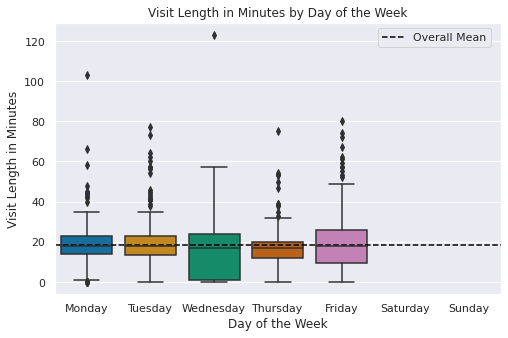

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

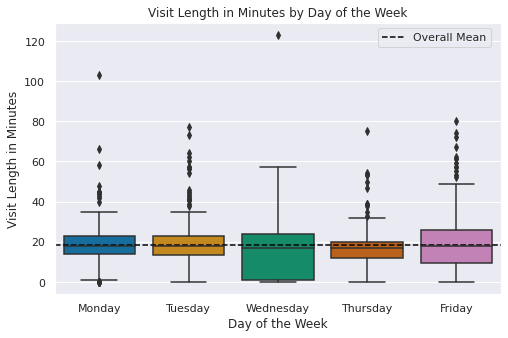

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

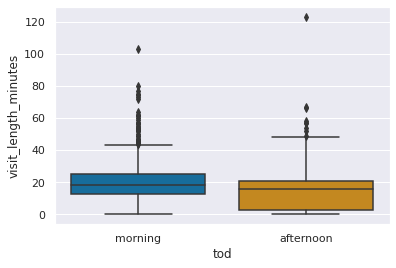

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

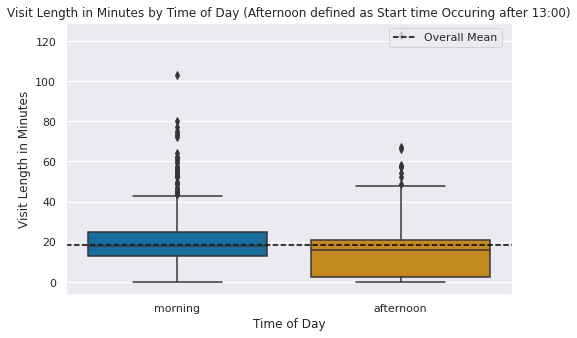

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

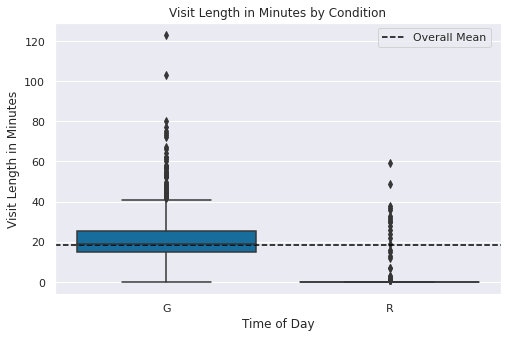

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

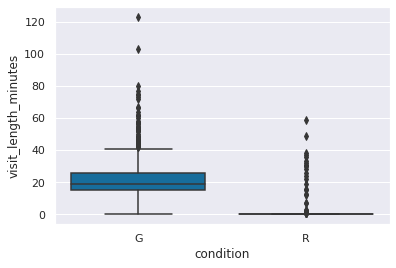

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

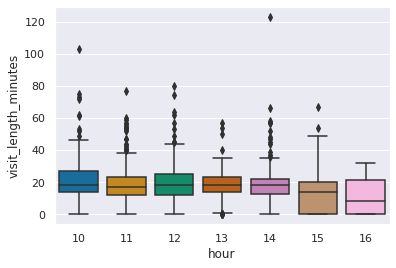

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

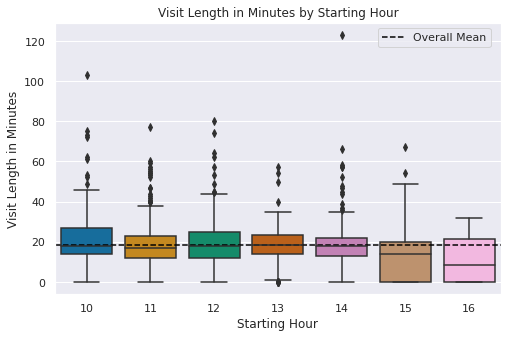

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   784.0000
mean                                     18.4337
std                                      15.0726
min                                       0.0000
25%                                      11.0000
50%                                      17.0000
75%                                      24.0000
max                                     123.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   791.0000
mean                                     22.1606
std                                      54.4808
min                                       0.0000
25%                                      12.0000
50%                                      18.0000
75%                                      24.0000
max                                   1,332.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

18.0

In [ ]:
df_outliers['visit_length'].describe()

count                          784
mean     0 days 00:18:26.020408163
std      0 days 00:15:04.356127137
min                0 days 00:00:00
25%                0 days 00:11:00
50%                0 days 00:17:00
75%                0 days 00:24:00
max                0 days 02:03:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          791
mean     0 days 00:20:20.404551201
std      0 days 00:28:32.407392134
min              -1 days +22:12:00
25%                0 days 00:11:30
50%                0 days 00:18:00
75%                0 days 00:24:00
max                0 days 05:26:00
Name: visit_length, dtype: object

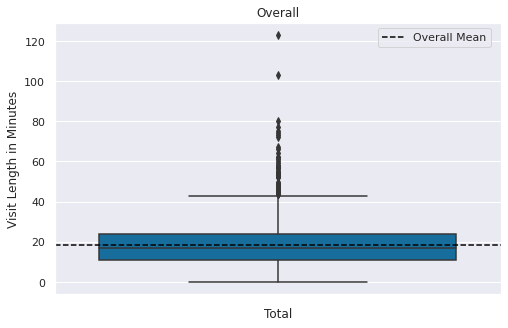

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
166
Eleven
202
Twelve
104
One
52
Two
153
Three
101
Four
6


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
102
Tuesday Outlier
195
Wednesday Outlier
181
Thursday Outlier
160
Friday Outlier
146
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       20.0000
Tuesday                                      19.1436
Wednesday                                    17.2928
Thursday                                     16.5625
Friday                                       19.8562
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
623
R
161


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    22.2632
R                                     3.6149
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
524
afternoon
260


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    16.4538
morning                                      19.4160
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
166
Eleven
202
Twelve
104
One
52
Two
153
Three
101
Four
6


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    20.8554
11                                    18.0941
12                                    20.1442
13                                    18.5000
14                                    18.4771
15                                    13.6535
16                                    12.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 188
newfrom                 188
newto                   188
visit_length            188
start_day               188
end_day                 188
sameday                 188
dayofweek               188
tod                     188
hour                    188
condition               188
visit_length_minutes    188
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 141
newfrom                 141
newto                   141
visit_length            141
start_day               141
end_day                 141
sameday                 141
dayofweek               141
tod                     141
hour                    141
condition               141
visit_length_minutes    141
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 643
newfrom                 643
newto                   643
visit_length            643
start_day               643
end_day                 643
sameday                 643
dayofweek               643
tod                     643
hour                    643
condition               643
visit_length_minutes    643
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:15:00,2021-11-30 11:15:00,0 days,30,30,equal,Tuesday,morning,11,G,0.0000
127,G1359,2021-12-07 12:17:00,2021-12-07 12:17:00,0 days,7,7,equal,Tuesday,morning,12,G,0.0000
215,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
221,G1457,2021-12-22 11:01:00,2021-12-22 11:01:00,0 days,22,22,equal,Wednesday,morning,11,G,0.0000
235,G1472,2021-12-23 12:27:00,2021-12-23 12:27:00,0 days,23,23,equal,Thursday,morning,12,G,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:15:00,2021-11-30 11:15:00,0 days,30,30,equal,Tuesday,morning,11,G,0.0000
127,G1359,2021-12-07 12:17:00,2021-12-07 12:17:00,0 days,7,7,equal,Tuesday,morning,12,G,0.0000
215,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
221,G1457,2021-12-22 11:01:00,2021-12-22 11:01:00,0 days,22,22,equal,Wednesday,morning,11,G,0.0000
235,G1472,2021-12-23 12:27:00,2021-12-23 12:27:00,0 days,23,23,equal,Thursday,morning,12,G,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
483,G1746,2022-01-19 14:25:00,2022-01-19 16:28:00,0 days 02:03:00,19,19,equal,Wednesday,afternoon,14,G,123.0000
530,G1796,2022-01-24 10:39:00,2022-01-24 12:22:00,0 days 01:43:00,24,24,equal,Monday,morning,10,G,103.0000
416,G1672,2022-01-14 12:13:00,2022-01-14 13:33:00,0 days 01:20:00,14,14,equal,Friday,morning,12,G,80.0000
77,G1306,2021-11-30 11:41:00,2021-11-30 12:58:00,0 days 01:17:00,30,30,equal,Tuesday,morning,11,G,77.0000
583,G1851,2022-01-27 10:51:00,2022-01-27 12:06:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,G,75.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
483,G1746,2022-01-19 14:25:00,2022-01-19 16:28:00,0 days 02:03:00,19,19,equal,Wednesday,afternoon,14,G,123.0000
530,G1796,2022-01-24 10:39:00,2022-01-24 12:22:00,0 days 01:43:00,24,24,equal,Monday,morning,10,G,103.0000
416,G1672,2022-01-14 12:13:00,2022-01-14 13:33:00,0 days 01:20:00,14,14,equal,Friday,morning,12,G,80.0000
77,G1306,2021-11-30 11:41:00,2021-11-30 12:58:00,0 days 01:17:00,30,30,equal,Tuesday,morning,11,G,77.0000
583,G1851,2022-01-27 10:51:00,2022-01-27 12:06:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,G,75.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
788,R1304,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10,R,326.0000
790,R1306,2022-01-28 10:30:00,2022-01-28 15:56:00,0 days 05:26:00,28,28,equal,Friday,morning,10,R,326.0000
789,R1305,2022-01-28 10:30:00,2022-01-28 15:55:00,0 days 05:25:00,28,28,equal,Friday,morning,10,R,325.0000
784,R1300,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday,morning,10,R,256.0000
786,R1302,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday,morning,10,R,256.0000
787,R1303,2022-01-27 10:04:00,2022-01-27 14:20:00,0 days 04:16:00,27,27,equal,Thursday,morning,10,R,256.0000
483,G1746,2022-01-19 14:25:00,2022-01-19 16:28:00,0 days 02:03:00,19,19,equal,Wednesday,afternoon,14,G,123.0000
530,G1796,2022-01-24 10:39:00,2022-01-24 12:22:00,0 days 01:43:00,24,24,equal,Monday,morning,10,G,103.0000
416,G1672,2022-01-14 12:13:00,2022-01-14 13:33:00,0 days 01:20:00,14,14,equal,Friday,morning,12,G,80.0000
77,G1306,2021-11-30 11:41:00,2021-11-30 12:58:00,0 days 01:17:00,30,30,equal,Tuesday,morning,11,G,77.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
483,G1746,2022-01-19 14:25:00,2022-01-19 16:28:00,0 days 02:03:00,19,19,equal,Wednesday,afternoon,14,G,123.0000
530,G1796,2022-01-24 10:39:00,2022-01-24 12:22:00,0 days 01:43:00,24,24,equal,Monday,morning,10,G,103.0000
416,G1672,2022-01-14 12:13:00,2022-01-14 13:33:00,0 days 01:20:00,14,14,equal,Friday,morning,12,G,80.0000
77,G1306,2021-11-30 11:41:00,2021-11-30 12:58:00,0 days 01:17:00,30,30,equal,Tuesday,morning,11,G,77.0000
583,G1851,2022-01-27 10:51:00,2022-01-27 12:06:00,0 days 01:15:00,27,27,equal,Thursday,morning,10,G,75.0000
193,G1428,2021-12-17 12:03:00,2021-12-17 13:17:00,0 days 01:14:00,17,17,equal,Friday,morning,12,G,74.0000
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday,morning,10,G,73.0000
413,G1669,2022-01-14 10:29:00,2022-01-14 11:41:00,0 days 01:12:00,14,14,equal,Friday,morning,10,G,72.0000
78,G1307,2021-12-03 15:14:00,2021-12-03 16:21:00,0 days 01:07:00,3,3,equal,Friday,afternoon,15,G,67.0000
438,G1697,2022-01-17 14:14:00,2022-01-17 15:20:00,0 days 01:06:00,17,17,equal,Monday,afternoon,14,G,66.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:21:00,2021-11-30 10:43:00,0 days 00:22:00,30,30,equal,Tuesday,morning,10,G,22.0000
1,G1223,2021-11-30 10:22:00,2021-11-30 11:35:00,0 days 01:13:00,30,30,equal,Tuesday,morning,10,G,73.0000
2,G1224,2021-11-30 10:31:00,2021-11-30 11:33:00,0 days 01:02:00,30,30,equal,Tuesday,morning,10,G,62.0000
3,G1225,2021-11-30 11:02:00,2021-11-30 11:44:00,0 days 00:42:00,30,30,equal,Tuesday,morning,11,G,42.0000
4,G1226,2021-11-30 10:44:00,2021-11-30 11:25:00,0 days 00:41:00,30,30,equal,Tuesday,morning,10,G,41.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
781,R1248,2022-01-26 12:20:00,2022-01-26 12:20:00,0 days 00:00:00,26,26,equal,Wednesday,morning,12,R,0.0000
782,R1250,2022-01-26 15:03:00,2022-01-26 15:03:00,0 days 00:00:00,26,26,equal,Wednesday,afternoon,15,R,0.0000
783,R1251,2022-01-26 15:27:00,2022-01-26 15:28:00,0 days 00:01:00,26,26,equal,Wednesday,afternoon,15,R,1.0000
785,R1301,2022-01-27 10:04:00,2022-01-27 10:42:00,0 days 00:38:00,27,27,equal,Thursday,morning,10,R,38.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
578,G1846,2022-01-26 16:15:00,2022-01-26 16:38:00,0 days 00:23:00,26,26,equal,Wednesday,afternoon,16,G,23.0000


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'HFA'
HFAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
HFAdf.to_csv('HFAdf.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
